## Implementation of ARSOM -  Association Rule Selection Optimization Model

We will use 'Association Rule Mining' and 'Mixed-Integer Programming'  to find the optimal rule set to correctly predict the positive class while minimizing the number of features used for prediction.


In [66]:
# Python Dataframe & numeric libraries
import pandas as pd
import numpy as np

# Association rule mining library
from mlxtend.frequent_patterns import apriori, association_rules

# Gurobi optimization library
import gurobipy as gp
from gurobipy import GRB

# Evaluation & Visualization libraries
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

### Read the data into pandas dataframe

Here we read the provided dataset which will be Matrix 'A' that represents ['datapoints' X 'features'].
- Column name for feature that resprents class must be 'Class'.
- Any unnecessary can be removed by passing their name in the list.

In [44]:
df = pd.read_csv("C://Users//dlekd//OneDrive//바탕 화면//lab_lee//chemical//pcm//dara_product//tot_r2.csv",encoding = 'cp949')

# Rename Class variable
df.rename(columns={'label': 'Class'},inplace=True)

# Remove columns not required
#df.drop(columns = ['System3','TRIAGE'], inplace=True)


In [45]:
df = df.set_index('Unnamed: 0',drop=True)

### Function definition for calculating coverage

- Coverage for a rule/feature is defined by number of positive/negative points covered by them.



In [18]:
def coverage(rule,klass):
    """ Function used to calculate coverage of a rule"""
    return(sum(df.loc[df['Class']==klass][rule].apply(lambda x: all(x), axis = 1)))

def check_rules(num,rules):
    """ Function used to create matrix C"""
    lis = []
    for i in rules.index:
        lis.append(int(all(df[rules['itemsets'][i]].loc[num])))
    return lis

def check_rules_features():
    itemsets_unraveled = arules.explode('itemsets')['itemsets']
    rules_features = pd.DataFrame(data = 0, index = df.columns[:-1], columns = arules.index)

    for i in itemsets_unraveled.iteritems():
        rules_features.loc[i[1]][i[0]] = 1
        
    return rules_features



## 1. Selecting relevant rules using Association rules

### Approach 'A': Regular Association rules

First we implement regular association rules technique that considers class as a feature(item).
Conclusively, we find out the association rules with class = 1.

- Here we mine for frequent itemsets using 'apriori algorithm'

In [46]:
frequent_itemsets = apriori(df, min_support=0.05, use_colnames = True)
frequent_itemsets

C:\Users\dlekd\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.076161,(1205|17|0)
1,0.118812,(8000|41|7)
2,0.073115,(63500|71|0)
3,0.060168,(7681|52|9)
4,0.072353,(128|37|0)
...,...,...
24702,0.054075,"(106|24|1, 120|51|4, 5989|27|5, 5392|40|5, 78|..."
24703,0.058644,"(106|24|1, 120|51|4, 5989|27|5, 5392|40|5, 78|..."
24704,0.051790,"(106|24|1, 120|51|4, 5392|40|5, 78|70|6, 7732|..."
24705,0.051790,"(106|24|1, 5989|27|5, 5392|40|5, 78|70|6, 7732..."


- Next, we select association rules with only 'Class' in RHS(consequent) since this will represent rules to identify positive class. 
- Coverage is calculated for both + (Tcovered) and - (Ncovered) datapoints.

In [48]:
arules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05)
arules = arules[arules['consequents'] == frozenset({'Class'})]
arules = arules[['antecedents','support','confidence','lift']]
arules['size'] = arules['antecedents'].apply(lambda x: len(x))
arules['Tcovered'] = arules['antecedents'].apply(lambda x: coverage(x,1))
arules['Ncovered'] = arules['antecedents'].apply(lambda x: coverage(x,0))
arules.rename(columns = {'antecedents': 'itemsets'}, inplace=True)
arules.reset_index(drop=True,inplace=True)
arules['itemsets'] = arules['itemsets'].apply(lambda x: list(x))
arules

,itemsets,support,confidence,lift,size,Tcovered,Ncovered
0,[1205|17|0],0.062452,0.820000,1.012850,1,82,18
1,[8000|41|7],0.096725,0.814103,1.005566,1,127,29
2,[63500|71|0],0.057121,0.781250,0.964987,1,75,21
3,[128|37|0],0.054075,0.747368,0.923137,1,71,24
4,[6132|04|3],0.067784,0.801802,0.990372,1,89,22
...,...,...,...,...,...,...,...
4989,"[80|54|6, 106|24|1, 78|70|6, 7732|18|5, 60|12|...",0.050267,0.804878,0.994172,7,66,16
4990,"[80|54|6, 106|24|1, 78|70|6, 7732|18|5, 18479|...",0.051790,0.819277,1.011958,7,68,15
4991,"[80|54|6, 106|24|1, 78|70|6, 7732|18|5, 106|22...",0.051028,0.720430,0.889863,7,67,26
4992,"[106|24|1, 1222|05|5, 78|70|6, 7732|18|5, 106|...",0.051028,0.744444,0.919525,7,67,23


- Matrix B is ['rules' X 'features'] matrix. For each rule we check if the feature is covered and mark it 1.

In [49]:
#Matrix B
rules_features = check_rules_features()
rules_features

,0,1,2,3,4,5,6,7,8,9,...,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993
1205|17|0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198404|98|7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33939|65|0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6290|03|5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8000|41|7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8007|46|3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13019|22|2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33530|46|0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61444|38|0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Matrix C is a ['datapoint' X 'rules'] matrix and we use check_rules() function to create it.

In [50]:
#Matrix C
df_rules_data = [check_rules(x,arules) for x in df.index]
df_rules = pd.DataFrame(data = df_rules_data, index = df.index, columns = arules.index)
df_rules['Class'] = df['Class']

df_rules

,0,1,2,3,4,5,6,7,8,9,...,4985,4986,4987,4988,4989,4990,4991,4992,4993,Class
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
아로마뷰 릴렉싱 라벤더,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
비앤비 섬유유연제 (베르가못),0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
비앤비 프리미엄 섬유유연제,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
생활감성 후루티후로랄머스크 섬유유연제,0,0,0,0,1,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
깨끗한 섬유유연제(오리엔탈 부케),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
실내용 액체 방향제 라벤더(48014),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
크로바방향제 아쿠아(47997),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
실내용 액체 방향제 숲속향(48015),0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## 2. OPTIMIZATION: Finding optimal rule set using integer programming

### Define the problem:


Our optimization problem is as follows:

**MIN:** $//alpha//  //Sigma y_j$ + $//beta //  //Sigma z_k$ + $//gamma //  //Sigma x_i^-$ - $//lambda //  //Sigma x_i^+$

**ST:**  $//Sigma$ $ c_{ik}^+ z_k //ge x_i // //  //forall //  i //in I^+ $

$//Sigma$ $ c_{ik}^- z_k //ge M_1 x_i // //  //forall //  i //in I^- $

$//Sigma$ $ b_{jk}^- z_k //ge M_2 y_j // //  //forall //  j //in J $

- Check the problem parameters (change 'l' if needed) in Gurobi and run the optimization model in following cell

In [51]:
gp.disposeDefaultEnv()

J,K,I_P,I=len(rules_features.index),len(rules_features.columns),df['Class'].sum(),len(df.index)

c_P_df = df_rules.loc[df_rules['Class'] == 1, df_rules.columns !='Class'].reset_index(drop=True).transpose()

c_N_df = df_rules.loc[df_rules['Class'] == 0, df_rules.columns !='Class'].reset_index(drop=True).transpose()

bf = rules_features.reset_index(drop = True).transpose()

# SET the lambda coefficient
l = 999

In [67]:
try:
    # Create a new model
    A = gp.Model("mip1")
    
    # Create variables
    x = A.addVars(I, vtype=GRB.BINARY, name="x")
    #xneg = A.addVars(10, vtype=GRB.BINARY, name="xneg")
    y = A.addVars(J, vtype=GRB.BINARY, name="y")
    z = A.addVars(K, vtype=GRB.BINARY, name="z")
    
    # Set objective
    
    A.setObjective(gp.quicksum(y[j] for j in range(J))+
                   gp.quicksum(z[k] for k in range(K))+
                   gp.quicksum(x[i] for i in range(I_P,I))-
                   l*gp.quicksum(x[i] for i in range(I_P)),
                   GRB.MAXIMIZE)
    
    # Add constraint: sigma{c_i_k+ * z_k} >= x_i
    for i in range(I_P):
        A.addConstr(gp.quicksum(c_P_df[i][k] * z[k] for k in range(K))>= x[i], name='con1')
    
    # Add constraint: sigma{c_i_k- * z_k} <= M_1 * x_i
    for i in range(I_P,I):
        i1=i-I_P
        A.addConstr(gp.quicksum(c_N_df[i1][k] * z[k] for k in range(K))<= (K+1) * x[i], name='con2')
    
    # Add constraint: sigma{b_j_k * z_k} <= M_2 * y_j
    for j in range(J):
        A.addConstr(gp.quicksum(bf[j][k] * z[k] for k in range(K))<= (K+1) * y[j], name='con3')
    
    # Optimize model
    A.optimize()
    
    for v in A.getVars():
            print('%s %g' % (v.varName, v.x))
    
    print('Obj: %g' % A.objVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 5600X 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Error code 10010: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license


- Now we subset arules dataframe to observe only the selected rules after optimization

In [68]:
z_rules = []
for v in A.getVars():
    if 'z' in v.varName:
        z_rules.append(bool(v))

#rules_final = [i for i in arules[z_rules].sort_values(by = 'support', ascending = False)['itemsets']]
rules_final = [i for i in arules[z_rules]['itemsets']]
rules_final

[['1205|17|0'],
 ['8000|41|7'],
 ['63500|71|0'],
 ['128|37|0'],
 ['6132|04|3'],
 ['68039|49|6'],
 ['32210|23|4'],
 ['140|11|4'],
 ['123|68|2'],
 ['101|84|8'],
 ['7631|86|9'],
 ['122|99|6'],
 ['14901|07|6'],
 ['17511|60|3'],
 ['120|51|4'],
 ['125|12|2'],
 ['61788|85|0'],
 ['84650|60|2'],
 ['127|51|5'],
 ['122|40|7'],
 ['57|55|6'],
 ['2634|33|5'],
 ['106|25|2'],
 ['5949|29|1'],
 ['34590|94|8'],
 ['1310|73|2'],
 ['5989|27|5'],
 ['142|19|8'],
 ['104|67|6'],
 ['142|92|7'],
 ['100|51|6'],
 ['42612|52|2'],
 ['91|64|5'],
 ['7647|14|5'],
 ['103|95|7'],
 ['7732|18|5'],
 ['63148|62|9'],
 ['6259|76|3'],
 ['106|24|1'],
 ['586|62|9'],
 ['97|53|0'],
 ['105|87|3'],
 ['60|12|8'],
 ['25265|71|8'],
 ['97|54|1'],
 ['105|95|3'],
 ['115|95|7'],
 ['78|70|6'],
 ['110|27|0'],
 ['80|56|8'],
 ['77|92|9'],
 ['118|58|1'],
 ['101|86|0'],
 ['112|31|2'],
 ['28219|61|6'],
 ['106|22|9'],
 ['18479|58|8'],
 ['88|41|5'],
 ['57378|68|4'],
 ['78|69|3'],
 ['56|81|5'],
 ['54464|57|2'],
 ['64|17|5'],
 ['80|54|6'],
 ['98|55|5']

## 3. Evaluation

Here we will use selected rules to predict the class of training dataset. Evaluation includes analyzing confusion matrix and the AUC plots.

- Calculate prediction probabilities for a datapoint using average support of all the rules that satisfy that datapoint.

In [73]:
y_predict_proba=[]

for j in df.index:
    colsup = []
    for i in arules[z_rules].index:
        if all(df.iloc[j,:][arules.iloc[i]['itemsets']]) == True:
            colsup.append(arules.iloc[i]['support'])
    try:
        y_predict_proba.append(sum(colsup)/len(colsup))
    except ZeroDivisionError:
        y_predict_proba.append(0)

y_predict_proba

[0,
 0,
 0.07554296506137866,
 0.06515580736543909,
 0.025495750708215296,
 0.06373937677053824,
 0.0339943342776204,
 0,
 0.0226628895184136,
 0.0481586402266289,
 0.06043437204910292,
 0.040604343720491036,
 0.05099150141643059,
 0.0906515580736544,
 0.07223796033994334,
 0,
 0.09348441926345609,
 0.07459867799811143,
 0.039660056657223795,
 0.06657223796033995,
 0.053824362606232294,
 0,
 0.09348441926345609,
 0.09348441926345609,
 0.046033994334277614,
 0,
 0.03824362606232294,
 0.0226628895184136,
 0,
 0.0226628895184136,
 0.07932011331444759,
 0.0679886685552408,
 0.042492917847025496,
 0.05099150141643059,
 0.0113314447592068,
 0.05099150141643059,
 0.05099150141643059,
 0.05311614730878188,
 0.09206798866855524,
 0.0906515580736544,
 0,
 0.039660056657223795,
 0.09348441926345609,
 0.0906515580736544,
 0.053824362606232294,
 0,
 0.09348441926345609,
 0.05099150141643059,
 0.05760151085930123,
 0.06515580736543909,
 0.07223796033994334,
 0.032577903682719546,
 0.0188857412653446

- Convert prediction probabilities to predicted class by converting to boolean.

In [74]:
y_predicted = [bool(i) for i in y_predict_proba]
y_predict_proba = np.array(y_predict_proba)

y_predicted

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 F

- Calculate and plot confusion matrix using predicted and true labels

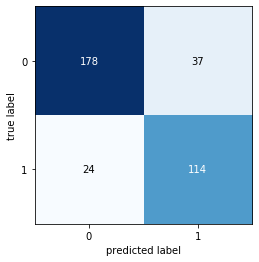

In [75]:
y_target = list(df['Class'])
cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [76]:
my_func = lambda x: 1-x

y_proba = np.vstack((y_predict_proba,[my_func(i) for i in y_predict_proba])).T
y_test = np.vstack((y_target,[my_func(i) for i in y_target])).T

y_proba

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.07554297, 0.92445703],
       [0.06515581, 0.93484419],
       [0.02549575, 0.97450425],
       [0.06373938, 0.93626062],
       [0.03399433, 0.96600567],
       [0.        , 1.        ],
       [0.02266289, 0.97733711],
       [0.04815864, 0.95184136],
       [0.06043437, 0.93956563],
       [0.04060434, 0.95939566],
       [0.0509915 , 0.9490085 ],
       [0.09065156, 0.90934844],
       [0.07223796, 0.92776204],
       [0.        , 1.        ],
       [0.09348442, 0.90651558],
       [0.07459868, 0.92540132],
       [0.03966006, 0.96033994],
       [0.06657224, 0.93342776],
       [0.05382436, 0.94617564],
       [0.        , 1.        ],
       [0.09348442, 0.90651558],
       [0.09348442, 0.90651558],
       [0.04603399, 0.95396601],
       [0.        , 1.        ],
       [0.03824363, 0.96175637],
       [0.02266289, 0.97733711],
       [0.        , 1.        ],
       [0.02266289, 0.97733711],
       [0.

- Plot the AUC curve by calculating FPR, TPR at different thresholds using roc_curve() function.

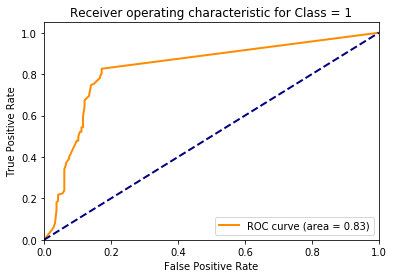

In [77]:
n_classes = len(set(df['Class']))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Class = 1')
plt.legend(loc="lower right")
plt.show()